In [1]:
# 아래 커맨드를 터미널에서 실행해 주세요
# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf
# pip install lightgbm

In [2]:
import warnings
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor,XGBClassifier # model
from xgboost import plot_importance # 중요변수 시각화
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.tree import export_graphviz
import warnings
import numpy as np
warnings.filterwarnings(action='ignore')

plt.rc('font', family='NanumBarunGothic') 
warnings.simplefilter("ignore")

In [3]:
PATH = r"./datas/"

In [4]:
# source_list = os.listdir(PATH)
# source_dict = dict()
# for idx, source in enumerate(source_list):
#   source_dict[idx]=source
source_dict={0: 'RND 정보_대회용_TB_BS_RND_I.csv',
  1: '기업 경쟁력 정보_대회용_TB_BS_COMPETE_I.csv',
  2: '사업화 보유 역량_대회용_TB_BS_BIZ_I.csv',
  3: '마케팅 보유 역량_대회용_TB_BS_HR_D.csv',
  4: '평판 정보_대회용_TB_BS_RI_I.csv',
  5: '국내 시장 동향_대회용_TB_BS_DMT_I.csv',
  6: '마케팅 역량 정보_대회용_TB_BS_MR_I.csv',
  7: '비즈니스모델 정보_대회용_TB_BS_BM_I.csv',
  8: '경쟁사 현황_대회용_TB_BS_CPT_I.csv',
  9: '산업분류코드_대회용_TB_BS_CODE_C.csv',
  10: '기술기반 보유 역량_대회용_TB_BS_IP_I.csv',
  11: '인적자원 보유 역량_대회용_TB_BS_HR_I.csv',
  12: '글로벌 시장 동향_대회용_TB_BS_GMT_I.csv'}
source_list=list(source_dict.values())

In [5]:
src_dict = dict()
for source in source_list:  
  try:
    df = pd.read_csv(PATH+source, encoding="euc-kr")
  except UnicodeDecodeError:
    df = pd.read_csv(PATH+source, encoding="utf-8")
  src_dict[source.split('.')[0]]=df

In [6]:
class AnalysisBigData:
  def __init__(self, *datas):
    self.datas=datas
    self.grades = {'A':0, 'B':1, 'C':2, 'D':3, 'E':4, 'F':5}
    self.output = None
    self.corr = None
    self.merge_datas()
  
  def merge_datas(self):
    output = None
    for data in self.datas:
      # print(data.columns)
      for col in data.columns:
        if col == '최종평판등급': continue # 최종평판점수->최종평판등급 classsification을 위한 범주로 변경
        # elif col in ['일반 평판 점수', '신용 평판 점수', '미래 평판 점수','최종평판점수']:
        elif "평판" in col:
          data.drop(col,axis=1,inplace=True)        
        elif col in ['최종평판점수']:
          # print(col)
          data.drop(col,axis=1,inplace=True)        
        elif len(data[col].value_counts())==1:
          data.drop(col,axis=1,inplace=True)
        elif data[col].dtype == 'object':
          data.drop(col,axis=1,inplace=True)
      if '사업자번호' not in data.columns.values:
        print('no 사업자번호')
        continue

      if output is None:
        output = data
      else:
        output = pd.merge(output, data, on='사업자번호', how='left')
    output.dropna(axis=1,inplace=True)
    output.drop('사업자번호',axis=1,inplace=True)
    corr = self.heatmap_func(output)
    self.output = output

  def heatmap_func(self,data):
    data_tmp = data.copy()
    data_tmp['최종평판등급'] = data_tmp['최종평판등급'].apply(lambda x: self.grades[x])
    corr = data_tmp.corr()
    self.corr = corr
    plt.figure(figsize=(15, 15));
    sns.heatmap(corr,
                vmax=0.8,
                linewidths=0.01,
                square=True,
                annot=True,
                cmap='YlGnBu',);
    plt.show()

  def get_data(self):
    # onehot_encoder = OneHotEncoder(sparse=False, categories='auto')
    # tmp_ar = np.eye(6)
    grades = {'A':0, 'B':1, 'C':2, 'D':3, 'E':4, 'F':5}
    labels = self.output.pop('최종평판등급') # 최종평판점수->최종평판등급 classsification을 위한 범주로 변경
    labels = labels.apply(lambda x: grades[x])
    return self.output, labels
  
  

# 데이터별 인덱스 매칭 정보
- 0: 'RND 정보_대회용_TB_BS_RND_I.csv',
- 1: '기업 경쟁력 정보_대회용_TB_BS_COMPETE_I.csv',
- 2: '사업화 보유 역량_대회용_TB_BS_BIZ_I.csv',
- 3: '마케팅 보유 역량_대회용_TB_BS_HR_D.csv',
- 4: '평판 정보_대회용_TB_BS_RI_I.csv',
- 5: '국내 시장 동향_대회용_TB_BS_DMT_I.csv',
- 6: '마케팅 역량 정보_대회용_TB_BS_MR_I.csv',
- 7: '비즈니스모델 정보_대회용_TB_BS_BM_I.csv',
- 8: '경쟁사 현황_대회용_TB_BS_CPT_I.csv',
- 9: '산업분류코드_대회용_TB_BS_CODE_C.csv',
- 10: '기술기반 보유 역량_대회용_TB_BS_IP_I.csv',
- 11: '인적자원 보유 역량_대회용_TB_BS_HR_I.csv',
- 12: '글로벌 시장 동향_대회용_TB_BS_GMT_I.csv

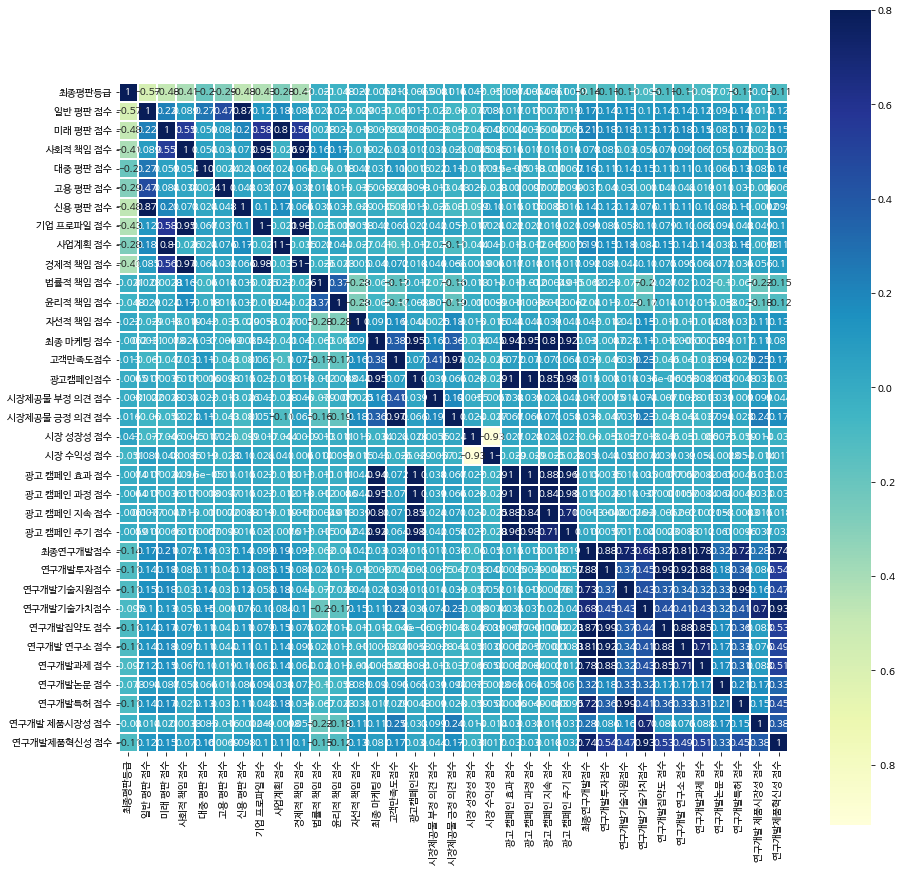

In [7]:
def accuracy_rate(test, pred):
  test = np.array(test, dtype=np.int16)
  test = test.reshape(-1,1)
  pred = np.array(pred, dtype=np.int16)
  pred = pred.reshape(-1,1)
  return np.mean(test==pred)

def get_data_input(idx):
  name = source_dict[idx]
  # print(name)
  return src_dict[name.split('.')[0]]

input_1, input_2, input_3 = get_data_input(4),get_data_input(6), get_data_input(0)
abd = AnalysisBigData(input_1, input_2,input_3)

# 분석 프로세스
- XGBoost
- RandomForest
- LightGBM

### 상관계수의 값은 낮게 나오나 여러 features의 값을 머신러닝에 적용해 보면 높은 정확도를 보입니다.

In [8]:
X,y = abd.get_data()
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, stratify=y)

## XGBoost

In [9]:
# model_xg = XGBClassifier(device='gpu', use_rmm=True)
model_xg = XGBClassifier(use_rmm=True)

[17:39:29] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

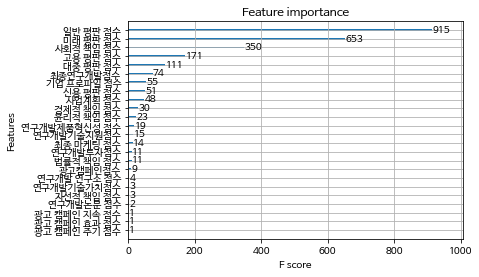

In [10]:
model_xg.fit(X_train, y_train)
plot_importance(model_xg)

In [11]:
pred_y = model_xg.predict(X_test)

In [12]:
mean_squared_error(y_test,pred_y)

0.00998003992015968

In [13]:
accuracy_rate(y_test,pred_y)

0.9900199600798403

## RandomForest

In [14]:
from sklearn.ensemble import RandomForestClassifier
model_rf = RandomForestClassifier()
model_rf.fit(X_train, y_train)
pred_y = model_rf.predict(X_test)
mean_squared_error(y_test,pred_y)

0.013972055888223553

In [15]:
accuracy_rate(y_test, pred_y)

0.9860279441117764

## lightGBM

In [16]:
from lightgbm import LGBMClassifier

# train_ds = lgb.Dataset(X_train, label = y_train)
# test_ds = lgb.Dataset(X_test, label = y_test)
params = {'learning_rate': 0.01,
          'max_depth': 16,
          'boosting': 'dart',# 'gbdt', 'rf', 'dart','goss'
          'objective': 'multiclass',
          'num_class':5,
          'metric': 'multi_logloss',
          'is_training_metric': True,
          'num_leaves': 144,
          'feature_fraction': 0.9,
          'bagging_fraction': 0.7,
          'bagging_freq': 5,
          'seed':2020}
model_lgb = LGBMClassifier(boosting_type='gbdt', num_leaves=100, max_depth=-1, learning_rate=0.01, n_estimators=5)
# model = lgb.train(params, train_ds, 10000, test_ds, verbose_eval=1000, early_stopping_rounds=100)
model_lgb.fit(X_train, y_train)
pred_y=model_lgb.predict(X_test)
mean_squared_error(y_test,pred_y)

0.22355289421157684

In [17]:
accuracy_rate(y_test, pred_y)

0.779441117764471

In [18]:
accuracy_rate(y_test,pred_y)

0.779441117764471